In [1]:
import os, sys, uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
from importlib import reload  
hm=reload(hm)
from iminuit import Minuit
from xgboost import XGBClassifier
import shap
import dill
from AppStatFunctions import Chi2Regression,UnbinnedLH, BinnedLH, add_text_to_ax, nice_string_output
from sklearn.preprocessing import RobustScaler
from hep_ml.reweight import GBReweighter

The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.


In [2]:
Nmax=2.4e6
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
ml1=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px']
ml2=['cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
features=['v0_ks_mass','v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
ML1=['v0_ks_mass','v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px']
ML2=['v0_ks_mass','cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']
featureml1=['v0_ks_mass','v0_chi2', 'v0_px1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_px2', 'v0_px']
ml1draw=np.hstack((['v0_ks_mass'], ml1))
featureml2=['v0_ks_mass','cosTheta', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_rxy','v0_z', 'ntrk_pv0']
ml2draw=np.hstack((['v0_ks_mass'], ml2))

In [3]:
N = Nmax*20
if N>Nmax:
#     N=Nmax
    print('Maxed out')

all_features = np.hstack((['v0_ks_mass'], uncorrelated))

path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "../../data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(np.hstack((all_features ,['trueKs'])), entrystop = N)
print(len(mc))
data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_data = data.sample(frac=0.7)
test_data = data[~data.index.isin(train_data.index)]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_mc = mc.sample(frac=0.7)
test_mc = mc[~mc.index.isin(train_mc.index)]

Maxed out
9254570


In [4]:
from scipy.optimize import curve_fit
from scipy.stats import norm, chi2

def fit_mass_double(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 17000], sigratio=2, depth=50, plot=True):
    """double gauss fit with mu_1=mu_2, with polynomial backgground fit: Give bincenter, vals, sig, a figure to plot, otherwise 
    it plots itself, guesses for both gaussian and background. Update might follow with updated estimation of guesses, but for
    the time being we use optimize.curvefit to give guesses for minuit
    
    Returns fig, ax, the full Minuit object, background amount and signal amount:
    """
    mask=vals>0
    xs, vals, errs=xs[mask], vals[mask], errs[mask]
    #look into automatizing the guesses
    mu, sigma, N = guesses_sig
    #Make a 5 sigma cut so only background is here
    bkgr_mask = (xs < mu-4*sigma) | (xs > mu+4*sigma)

    guesses_bkgr[-1] = (vals[np.argmin(xs-mu)]+vals[0]+vals[-1])/4
    if not ax and plot:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

    def background_fit(x, a, b, c, d):
        return a * (x-mu) ** 3 + b * (x-mu) ** 2 + c * (x-mu) + d
    
    # The signal fit  Here gauss
    def sig1(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    def sig2(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, f, sigmp, a, b, c, d):
        return background_fit(x, a, b, c, d) + f*sig1(x, mean, sig, size) + (1-f)*sig2(x, mean, sigmp*sig, size)
    
     # Background fit under here
    if sum(vals[bkgr_mask])==0:
        def background_fit(xs, a, b, c, d):
            return 0*xs
        b1, b2, b3, b4=0,0,0,0
    else:
        vals_b, cov_b = curve_fit(background_fit, xs[bkgr_mask], vals[bkgr_mask], p0 = guesses_bkgr)
        b1, b2, b3, b4 = vals_b
        bkgr_chi2 = Chi2Regression(background_fit, xs[bkgr_mask], vals[bkgr_mask], errs[bkgr_mask])
        bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
        bkgr_min.migrad()
        counter = 0
        bkgr_min
        while not bkgr_min.valid and counter<depth:
            bkgr_min.migrad()
            counter += 1
        if not bkgr_min.valid: print("No background valid minimum found!")

        #Save guesses 
        b1, b2, b3, b4 = bkgr_min.args
    N=(max(vals[~bkgr_mask])- background_fit(xs[np.argmax(xs[~bkgr_mask])], b1, b2, b3, b4))*30
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = mu, sig = sigma, size = N, f = 0.5, sigmp = sigratio)

    full_min.migrad()
    counter = 0
    while not full_min.valid and counter<5*depth:
        full_min = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
        mean = mu, sig = sigma*np.random.uniform(0.8,1.2), size = N*np.random.uniform(0.8,1.2),\
        f = 0.5*np.random.uniform(0.8,1.2), sigmp = sigratio*np.random.uniform(0.8,1.2))
        full_min.migrad()
        counter += 1
    if not full_min.valid: print(f"No valid double gaussian minimum found after {counter} tries!")

    mean, sig, size, f, sigmp, b1, b2, b3, b4 = full_min.args

    sig_amount = np.sum(abs(f*sig1(xs, mean, sig, size)) + (1-f)*abs(sig2(xs, mean, sigmp*sig, size)))
    bkg_amount = np.sum(abs(background_fit(xs, b1, b2, b3, b4)))
    if plot:
        ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
        ax_all.plot(xs, background_fit(xs, b1, b2, b3, b4),'b--',  label = "background_fit")

        ax_all.legend(loc = "upper right")

        # Details:
        text = {'chi2': full_min.fval, \
                'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
                'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
                'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}

        text_output = nice_string_output(text)
        add_text_to_ax(0.55, 0.925, text_output, ax_all)

        # Plot signal seperately
        ax_sig.fill_between(xs, f*sig1(xs, mean, sig, size) + (1-f)*sig2(xs, mean, sigmp*sig, size), color = 'red', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, f*sig1(xs, mean, sig, size),ls = '--', color = 'blue', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, (1-f)*sig2(xs, mean, sigmp*sig, size),ls = '--', color = 'green', alpha = 0.5, label = "sig fit")

        vals_sig = vals - background_fit(xs, b1, b2, b3, b4)

        ax_sig.plot(xs, vals_sig, 'r.')
        ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')



        text_a = {'sig_tight': np.round(f*sig_amount), \
                  'sig_broad': np.round((1-f)*sig_amount), \
                  'bkgr': np.round(bkg_amount), \
                  'sig/bkgr': sig_amount / bkg_amount}

        text_output = nice_string_output(text_a, decimals = 2)
        add_text_to_ax(0.60, 0.90, text_output, ax_sig)

        fig.tight_layout()
        return fig, ax, full_min, sig_amount, bkg_amount
    return full_min, sig_amount, bkg_amount

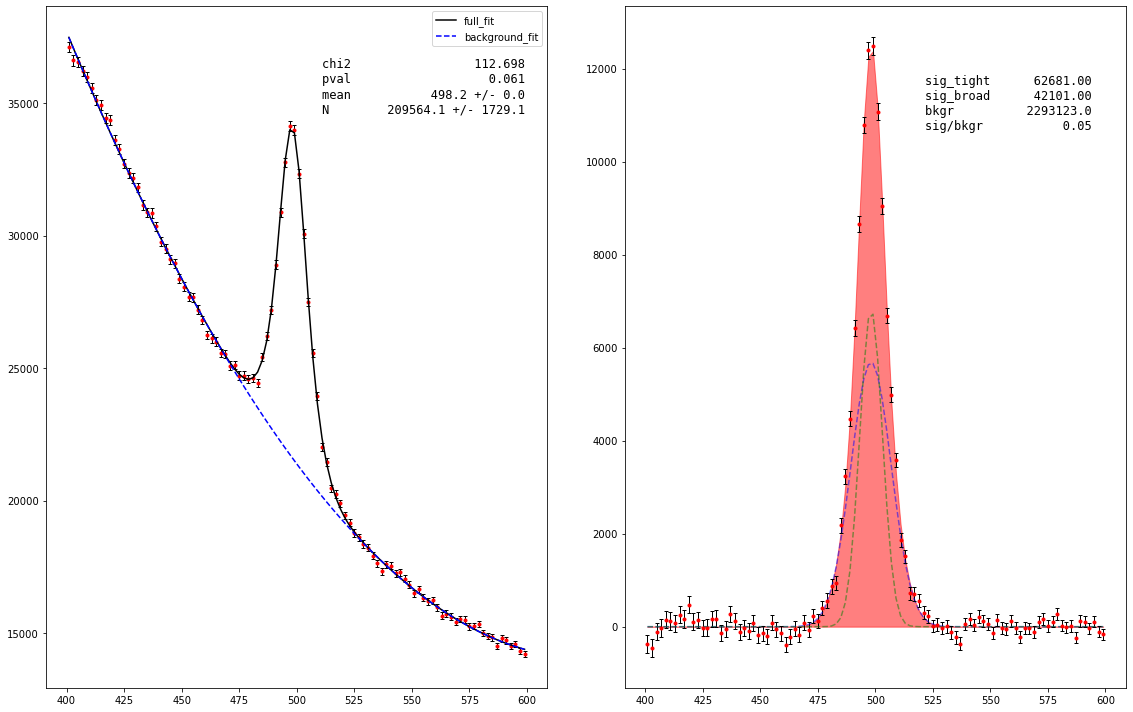

In [5]:
y, x, _ = hm.hist(data.v0_ks_mass, bins=100, range=(400,600))
fig, ax, fit, signal, bkgr = fit_mass_double(x, y, np.sqrt(y), guesses_sig=[498.9, 6, 20000])

(498.19835241641607, 8.953636549258274)

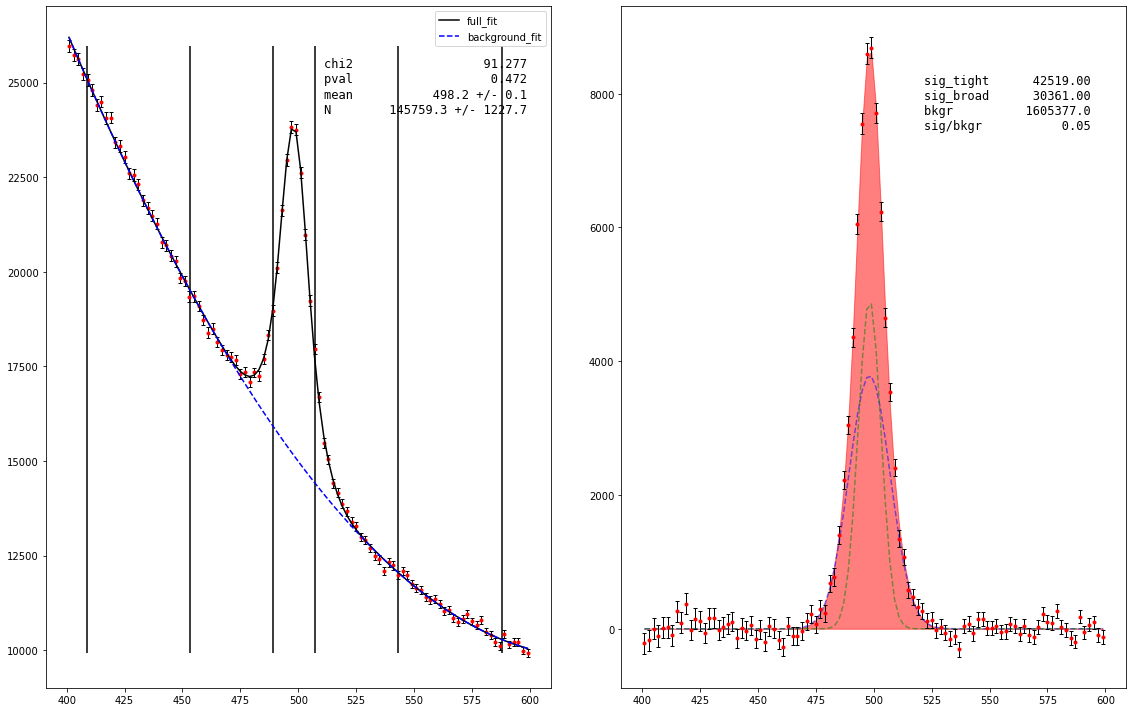

In [6]:
y, x, _ = hm.hist(train_data.v0_ks_mass,bins=100, range=(400,600))
fig, ax, M, sig, bkgr = fit_mass_double(x,y,np.sqrt(y), guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 20000])
mean, sigma = M.values['mean'], M.values['sig']
signal = train_data.loc[(train_data.v0_ks_mass > mean - sigma) & (train_data.v0_ks_mass < mean + sigma)]
bkgr_l = train_data.loc[(train_data.v0_ks_mass > mean - 10*sigma) & (train_data.v0_ks_mass < mean - 5*sigma)]
bkgr_r = train_data.loc[(train_data.v0_ks_mass > mean + 5*sigma) & (train_data.v0_ks_mass < mean + 10*sigma)]
ax[0].vlines([mean-sigma,mean+sigma,mean-10*sigma,mean-5*sigma,mean+5*sigma,mean+10*sigma],min(y),max(y))

min_sample = min([len(signal),len(bkgr_l),len(bkgr_r)])
if min_sample != len(signal):print("WARNING! decrease background sample size or increase signal sample size")


train_data_cut = pd.concat([signal.sample(min_sample),
                   bkgr_l.sample(min_sample),
                   bkgr_r.sample(min_sample)])
train_data_cut['y'] = np.append(np.ones(min_sample),[np.zeros(min_sample),np.zeros(min_sample)])
mean, sigma

In [7]:
import xgboost
model_XG=xgboost.XGBClassifier()
setattr(model_XG, 'verbosity', 1)
model_XG.fit(train_data_cut[uncorrelated],y=train_data_cut.y)

XGBClassifier()

In [8]:
p_XGall = model_XG.predict_proba(test_data[uncorrelated])[:,0]

Completed fit with Chi2: 129.8, p-val: 0.005 and the total amount of signal 31686 +/- 263, background: 687579
Completed fit with Chi2: 128.4, p-val: 0.006 and the total amount of signal 24941 +/- 341, background: 687132
Completed fit with Chi2: 128.1, p-val: 0.006 and the total amount of signal 18836 +/- 234, background: 686043
Completed fit with Chi2: 129.5, p-val: 0.005 and the total amount of signal 13344 +/- 213, background: 684344
Completed fit with Chi2: 132.9, p-val: 0.003 and the total amount of signal 8068 +/- 350, background: 682426
Completed fit with Chi2: 131.1, p-val: 0.004 and the total amount of signal 3883 +/- 141, background: 679419
Completed fit with Chi2: 136.3, p-val: 0.001 and the total amount of signal 1161 +/- 313, background: 674949
Completed fit with Chi2: 147.3, p-val: 0.000 and the total amount of signal 338 +/- 220, background: 668578
Completed fit with Chi2: 153.4, p-val: 0.000 and the total amount of signal 213 +/- 242, background: 661510
Completed fit wit

No valid minimum found!
Completed fit with Chi2: 107.8, p-val: 0.111 and the total amount of signal 12646 +/- 21637, background: 167171
Completed fit with Chi2: 111.0, p-val: 0.075 and the total amount of signal 12489 +/- 508, background: 160136
Completed fit with Chi2: 112.7, p-val: 0.061 and the total amount of signal 13036 +/- 2736, background: 152396
Completed fit with Chi2: 115.6, p-val: 0.042 and the total amount of signal 13172 +/- 642, background: 145068
Completed fit with Chi2: 111.4, p-val: 0.072 and the total amount of signal 13673 +/- 170, background: 137374
Completed fit with Chi2: 109.9, p-val: 0.086 and the total amount of signal 13034 +/- 290, background: 130819
Completed fit with Chi2: 103.8, p-val: 0.170 and the total amount of signal 12307 +/- 236, background: 124354
Completed fit with Chi2: 104.2, p-val: 0.163 and the total amount of signal 11905 +/- 229, background: 117563
Completed fit with Chi2: 101.5, p-val: 0.212 and the total amount of signal 11322 +/- 350, ba

No handles with labels found to put in legend.


Completed fit with Chi2: 127.6, p-val: 0.007 and the total amount of signal 9046 +/- 34, background: -1853


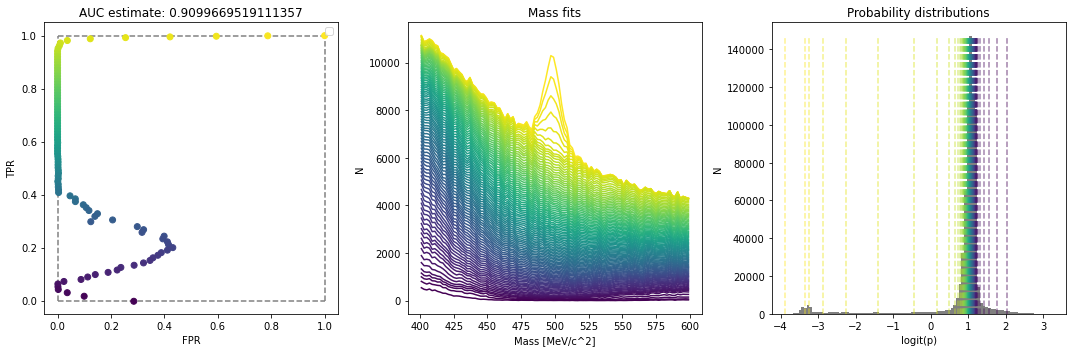

In [9]:
fig1, ax1=plt.subplots(nrows=1,ncols=3, figsize=(15,5))
hm.roc_curve_data(test_data.v0_ks_mass, p_XGall, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1[0] , c=1,
                  ax_fits=ax1[1], ax_hist=ax1[2],verbose = True, plimit = 0.01)
fig1.tight_layout()
fig1.savefig(fname='roc_auc_all_comp.pdf')

Completed fit with Chi2: 129.8, p-val: 0.005 and the total amount of signal 31686 +/- 263, background: 687579
Completed fit with Chi2: 128.9, p-val: 0.006 and the total amount of signal 27247 +/- 368, background: 684825
Completed fit with Chi2: 129.0, p-val: 0.005 and the total amount of signal 23602 +/- 271, background: 681277
Completed fit with Chi2: 130.0, p-val: 0.005 and the total amount of signal 20261 +/- 237, background: 677426
Completed fit with Chi2: 130.5, p-val: 0.004 and the total amount of signal 17146 +/- 189, background: 673349
Completed fit with Chi2: 128.7, p-val: 0.006 and the total amount of signal 14699 +/- 233, background: 668602
Completed fit with Chi2: 128.7, p-val: 0.006 and the total amount of signal 12976 +/- nan, background: 663133
Completed fit with Chi2: 126.9, p-val: 0.008 and the total amount of signal 11530 +/- 359, background: 657387
No valid minimum found!
Completed fit with Chi2: 124.4, p-val: 0.011 and the total amount of signal 10709 +/- 622, backg

Completed fit with Chi2: 114.9, p-val: 0.046 and the total amount of signal 839 +/- 195, background: 178978
Completed fit with Chi2: 105.5, p-val: 0.141 and the total amount of signal 1088 +/- 203, background: 171537
Completed fit with Chi2: 110.8, p-val: 0.078 and the total amount of signal 1133 +/- 143, background: 164299
Completed fit with Chi2: 105.6, p-val: 0.141 and the total amount of signal 4299 +/- 377, background: 153940
Completed fit with Chi2: 99.4, p-val: 0.256 and the total amount of signal 6864 +/- 550, background: 144182
No valid minimum found!
Completed fit with Chi2: 98.0, p-val: 0.290 and the total amount of signal 6611 +/- 19137, background: 137243
Completed fit with Chi2: 88.8, p-val: 0.546 and the total amount of signal 5383 +/- 676, background: 131279
Completed fit with Chi2: 95.5, p-val: 0.352 and the total amount of signal 4705 +/- 1186, background: 124763
Completed fit with Chi2: 100.0, p-val: 0.244 and the total amount of signal 6013 +/- 264, background: 1162

No handles with labels found to put in legend.


Completed fit with Chi2: 50.5, p-val: 0.173 and the total amount of signal 51 +/- 61, background: 7143


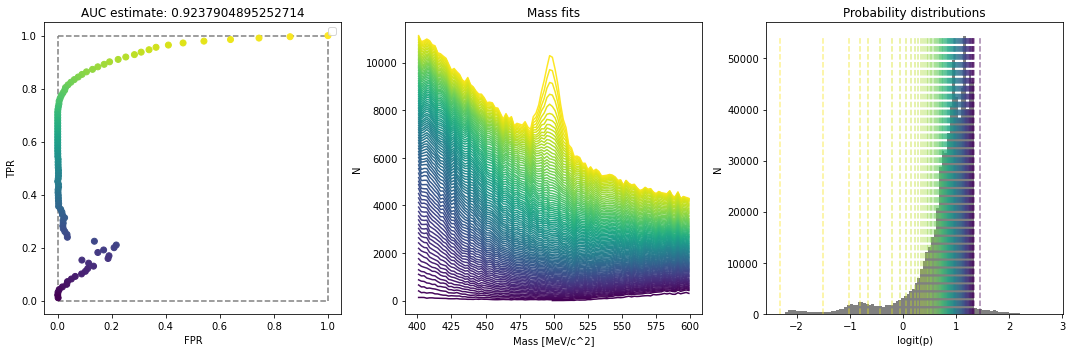

In [10]:
model_XG=xgboost.XGBClassifier()

setattr(model_XG, 'verbosity', 1)
model_XG.fit(train_data_cut[ml1],y=train_data_cut.y)
p_XG1 = model_XG.predict_proba(test_data[ml1])[:,0]
fig1, ax1=plt.subplots(nrows=1,ncols=3, figsize=(15,5))
hm.roc_curve_data(test_data.v0_ks_mass, p_XG1, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1[0] , c=1,
                  ax_fits=ax1[1], ax_hist=ax1[2],verbose = True, plimit = 0.01)
fig1.tight_layout()
fig1.savefig(fname='roc_auc_ml1_comp.pdf')

Completed fit with Chi2: 129.8, p-val: 0.005 and the total amount of signal 31686 +/- 263, background: 687579
Completed fit with Chi2: 129.7, p-val: 0.005 and the total amount of signal 24823 +/- 28200, background: 687250
Completed fit with Chi2: 129.6, p-val: 0.005 and the total amount of signal 18780 +/- 233, background: 686099
Completed fit with Chi2: 129.4, p-val: 0.005 and the total amount of signal 13180 +/- 385, background: 684507
Completed fit with Chi2: 132.7, p-val: 0.003 and the total amount of signal 7912 +/- 0, background: 682582
Completed fit with Chi2: 131.5, p-val: 0.004 and the total amount of signal 3759 +/- 510, background: 679543
Completed fit with Chi2: 138.4, p-val: 0.001 and the total amount of signal 1002 +/- 305, background: 675107
Completed fit with Chi2: 147.3, p-val: 0.000 and the total amount of signal 351 +/- 15, background: 668566
Completed fit with Chi2: 150.9, p-val: 0.000 and the total amount of signal 200 +/- 7, background: 661524
Completed fit with C

Completed fit with Chi2: 104.8, p-val: 0.153 and the total amount of signal 2617 +/- 232, background: 162814
Completed fit with Chi2: 98.7, p-val: 0.272 and the total amount of signal 2946 +/- 455, background: 155294
Completed fit with Chi2: 98.1, p-val: 0.286 and the total amount of signal 3114 +/- 260, background: 147932
Completed fit with Chi2: 98.5, p-val: 0.277 and the total amount of signal 2962 +/- 411, background: 140891
Completed fit with Chi2: 103.6, p-val: 0.174 and the total amount of signal 3956 +/- 268, background: 132706
Completed fit with Chi2: 110.1, p-val: 0.084 and the total amount of signal 3125 +/- 283, background: 126343
Completed fit with Chi2: 120.3, p-val: 0.021 and the total amount of signal 2901 +/- 605, background: 119375
Completed fit with Chi2: 121.0, p-val: 0.019 and the total amount of signal 3337 +/- 242, background: 111746
Completed fit with Chi2: 119.7, p-val: 0.023 and the total amount of signal 3308 +/- 319, background: 104582
Completed fit with Chi

No handles with labels found to put in legend.


Completed fit with Chi2: 193.2, p-val: 0.000 and the total amount of signal 6692 +/- 28, background: 502


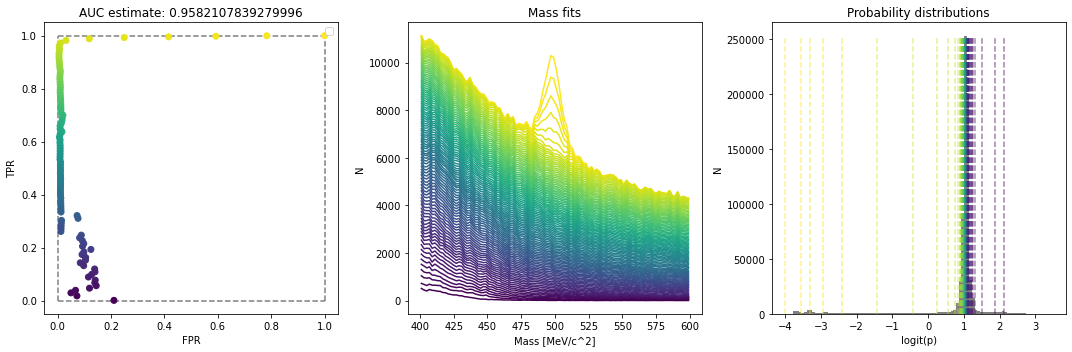

In [11]:
model_XG=xgboost.XGBClassifier()

setattr(model_XG, 'verbosity', 1)
model_XG.fit(train_data_cut[ml2],y=train_data_cut.y)
p_XG2 = model_XG.predict_proba(test_data[ml2])[:,0]
fig1, ax1=plt.subplots(nrows=1,ncols=3, figsize=(15,5))
hm.roc_curve_data(test_data.v0_ks_mass, p_XG2, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1[0] , c=1,
                  ax_fits=ax1[1], ax_hist=ax1[2],verbose = True, plimit = 0.01)
fig1.tight_layout()
fig1.savefig(fname='roc_auc_ml2_comp.pdf')

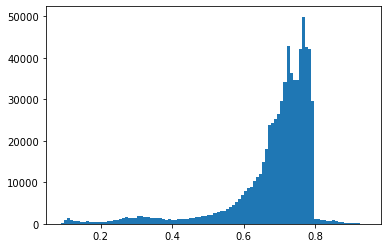

In [12]:
plt.hist(p_XG1, bins=100);
true1=p_XG1<0.2

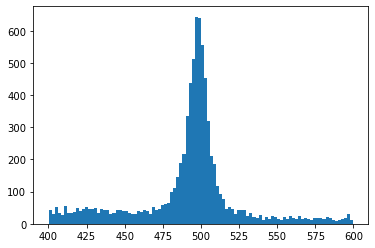

In [13]:
plt.hist(test_data.v0_ks_mass[true1], bins=100);

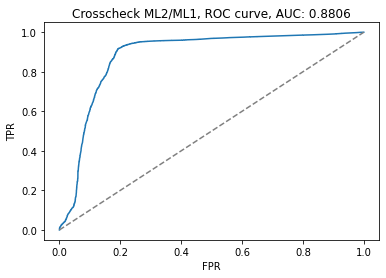

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true=true1, y_score=p_XG2)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set(xlabel='FPR', ylabel='TPR')
ax.set_title(f'Crosscheck ML2/ML1, ROC curve, AUC: {np.round(1-roc_auc_score(y_true=true1,y_score=p_XG2),4)}')
plt.savefig('cross_roc_ml1validate.pdf')

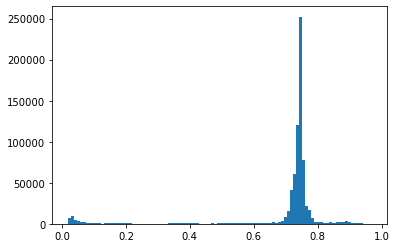

In [15]:
plt.hist(p_XG2, bins=100);
true2=p_XG2<0.25

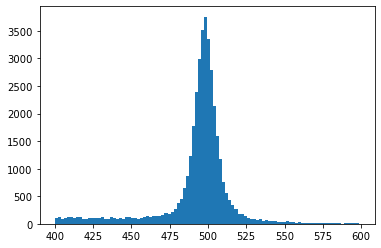

In [16]:
plt.hist(test_data.v0_ks_mass[true2], bins=100);

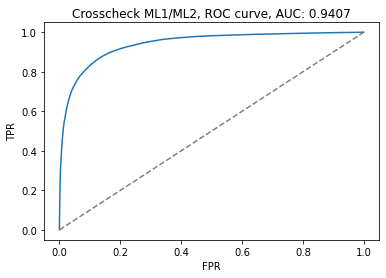

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true=true2, y_score=p_XG1)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set_title(f'Crosscheck ML1/ML2, ROC curve, AUC: {np.round(1-roc_auc_score(y_true=true2,y_score=p_XG1),4)}')
ax.set(xlabel='FPR', ylabel='TPR')
plt.savefig('cross_roc_ml2validate.pdf')

In [18]:
model_XG=xgboost.XGBClassifier()

setattr(model_XG, 'verbosity', 1)
model_XG.fit(test_mc[uncorrelated],y=test_mc.trueKs)

XGBClassifier()

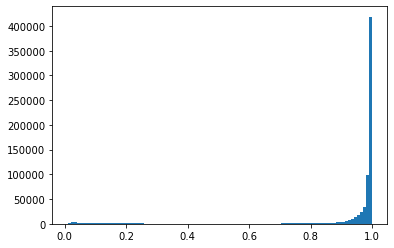

In [19]:
pmc=model_XG.predict_proba(test_data[uncorrelated])[:,0]
plt.hist(pmc, bins=100);
truemc=pmc<0.2

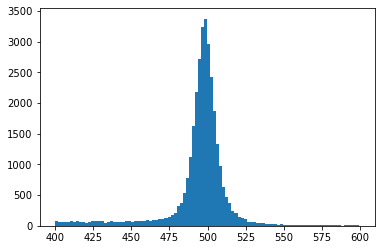

In [20]:
plt.hist(test_data.v0_ks_mass[truemc], bins=100);

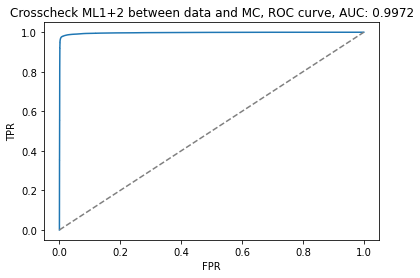

In [21]:
fpr, tpr, thresholds = roc_curve(y_true=truemc, y_score=p_XGall)

fig, ax = plt.subplots()
ax.plot(tpr,fpr)
ax.plot([0,1],[0,1],c='grey',linestyle='--')
ax.set(xlabel='FPR', ylabel='TPR')
ax.set_title(f'Crosscheck ML1+2 between data and MC, ROC curve, AUC: {np.round(1-roc_auc_score(y_true=truemc,y_score=p_XGall),4)}')
plt.savefig('cross_roc_mcvalidate.pdf')